# LogisticRegression

## Import and Load Data Set

In [25]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import RFE
from verstack.stratified_continuous_split import scsplit 
from datetime import datetime
from pandas import DataFrame
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import sklearn.decomposition as skdc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as sklm 
import sklearn.pipeline as skpl
import re
import matplotlib.pyplot as plt

In [2]:
# Load the training data
train_data = pd.read_csv("data/train.csv")
train_data.head(3)

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_mentions,urls,hashtags,text
0,0,1588696955143,0,False,68460,1101,1226,NaN,NaN,NaN,Smh I give up
1,1,1588464948124,0,False,309,51,202,NaN,NaN,NaN,"Most of us are Human Beings, but I think you m..."
2,2,1588634673360,0,False,3241,1675,2325,NaN,NaN,NaN,"Old dirty tricks Trump, at it again...like we ..."


In [3]:
train_data.shape

(665777, 11)

## Preprocessing

In [4]:
class FeatureExtraction(object):

    def __init__(self, train_data):
        self.train_data = train_data
    
    def transform(self):
        train_data = self.train_data
        
        #timestamp
        train_data["user_hour"] = train_data.timestamp.apply(lambda t: (datetime.fromtimestamp(t//1000-5*3600)).hour)
        train_data["user_day"] = train_data.timestamp.apply(lambda t: (datetime.fromtimestamp(t//1000-5*3600)).weekday())
        train_data["user_month"] = train_data.timestamp.apply(lambda t: (datetime.fromtimestamp(t//1000-5*3600)).month)
        
        #number of hashtags
        train_data['totalhashtag'] = train_data['hashtags'].str.split().str.len()
        train_data['totalhashtag'] = train_data['totalhashtag'].fillna(0)
        train_data = train_data.drop(columns=['hashtags'])
        
        #user verified
        labelencoder=LabelEncoder()
        train_data['user_verified']=labelencoder.fit_transform(train_data['user_verified'])
        
        # urls
        train_data['urls'] = train_data['urls'].fillna(0)
        train_data = train_data.assign(urls=(train_data['urls'] !=0 ).astype(int))
        
        # mentions
        train_data['user_mentions'] = train_data['user_mentions'].fillna(0)
        train_data = train_data.assign(user_mentions=(train_data['user_mentions']!= 0 ).astype(int))
        
        self.transformed_data = train_data
        pass

## Analysis

In [27]:
train_data.groupby('retweet_count').mean()

,id,timestamp,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_hour,user_day,user_month,totalhashtag
retweet_count,,,,,,,,,,
0,332823.257449,1.588504e+12,0.021637,32939.140042,6.118224e+03,1561.499812,12.604724,3.145413,4.948645,0.000000
1,333495.924039,1.588487e+12,0.214983,49078.294754,1.163302e+05,3395.315379,12.666795,2.697957,4.858698,0.585060
2,332457.805067,1.588483e+12,0.438973,69329.714360,7.757051e+05,5991.614108,12.021902,2.981886,4.872727,0.512795
3,332065.873257,1.588522e+12,0.557570,65906.830165,2.190506e+06,7951.069806,11.989739,2.761358,4.925539,0.344082


First observation :<br>
* La moyenne des followers augmente quand notre tweet a ete RT
* La moyenne des amis augmente quand notre tweet a ete RT
* L'utilisateur a plus tendance a etre verifie lorsque son tweet a ete RT

In [28]:
train_data = train_data.drop(columns=['text'])

KeyError: "['text'] not found in axis"

In [29]:
datacorr = train_data.corr()
datacorr.head()

,id,timestamp,retweet_count,user_verified,user_statuses_count,user_followers_count,user_friends_count,user_hour,user_day,user_month,totalhashtag
id,1.000000,-0.000258,-0.000576,0.000932,0.000611,0.001433,0.002043,0.000113,-0.000872,-0.000906,0.001048
timestamp,-0.000258,1.000000,-0.012517,0.005081,0.004274,0.012339,0.002441,-0.010344,-0.583776,0.436845,-0.013471
retweet_count,-0.000576,-0.012517,1.000000,0.497393,0.125498,0.199544,0.109533,-0.027470,-0.060642,-0.088498,0.274102
user_verified,0.000932,0.005081,0.497393,1.000000,0.198346,0.235241,0.049641,-0.007619,-0.043877,-0.046219,0.093272
user_statuses_count,0.000611,0.004274,0.125498,0.198346,1.000000,0.172699,0.150665,0.014659,-0.016374,-0.024173,-0.001115


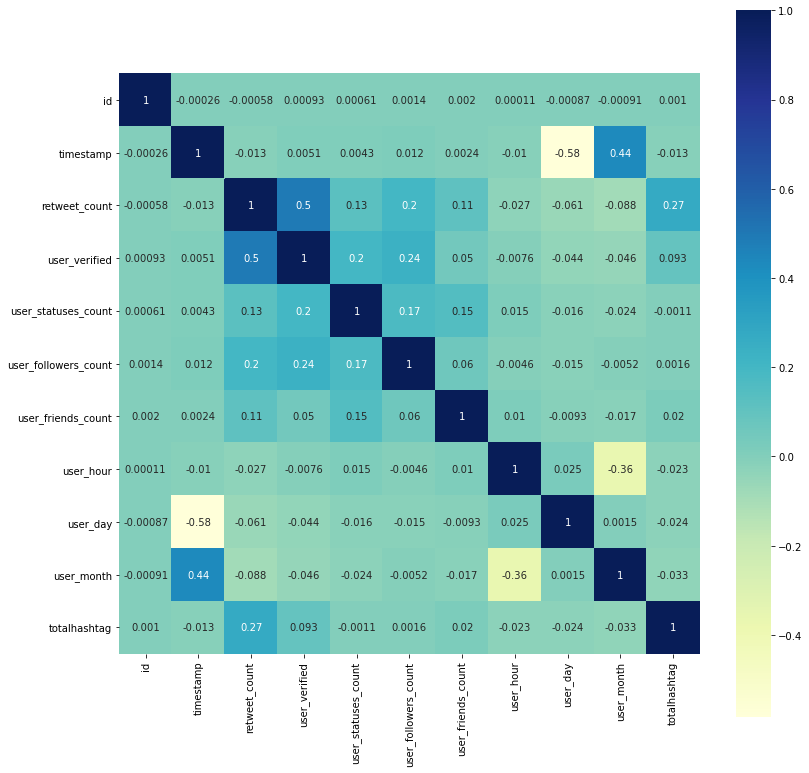

In [30]:
plt.figure(figsize = (13,13))
sns.heatmap(datacorr, cmap = 'YlGnBu',square=True,annot=True)

* the features that are highly correlated are the **number of followers**, **number of followees** and **number of statuses** and **user_verified** and also the **month** and if he puts **url**, which have a positive impact in the number of retweets

## Logistic Regression


In [9]:
y = train_data.retweet_count 
for i in range(train_data.shape[0]):
       if y[i] == 0:
            y[i] = 0
       elif y[i]>0 and y[i]<10:
            y[i] = 1
       elif y[i]>10 and y[i]<100:
            y[i] = 2
       else:
            y[i] = 3

In [10]:
FE = FeatureExtraction(train_data)
FE.transform()
features = FE.transformed_data

In [11]:
X = features.drop("retweet_count",axis=1)

In [13]:
X_train, X_test, y_train, y_test = scsplit(X, y, stratify=y, train_size=0.7,test_size=0.3)
train_data_model = LogisticRegression()
train_data_model.fit(X_train,y_train)
y_pred=train_data_model.predict(X_test)

In [14]:
metrics.mean_absolute_error(y_test, y_pred)

0.5774079525769273

In [15]:
acc = accuracy_score(y_test,y_pred)
acc

0.635054622648122

## Evaluation 

In [16]:
eval_data = pd.read_csv("data/evaluation.csv")
FE_eval = FeatureExtraction(eval_data)
FE_eval.transform()

In [20]:
trans_eval_data = FE_eval.transformed_data
X_eval = trans_eval_data.drop("text",axis=1)

In [21]:
sc = StandardScaler()
X_eval = sc.fit_transform(X_eval.values)

## Prediction for Logistic Regression

In [23]:
y_eval_pred_logistic = train_data_model.predict(X_eval)

In [26]:
with open("logistic_regression.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    for index, prediction in enumerate(y_eval_pred_logistic):
        writer.writerow([str(trans_eval_data['id'].iloc[index]) , str(int(prediction))])